<a href="https://colab.research.google.com/github/ZakiyQirosM/GLAURA-model/blob/main/GLAURA_resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
import torchvision
import os
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image
import torch
import random
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm

In [ ]:
!pip install kaggle

In [ ]:
!kaggle datasets download -d deathtrooper/glaucoma-dataset-eyepacs-airogs-light-v2 -p /content/sample_data

Dataset URL: https://www.kaggle.com/datasets/deathtrooper/glaucoma-dataset-eyepacs-airogs-light-v2
License(s): other
 99% 521M/524M [00:05<00:00, 89.7MB/s]
100% 524M/524M [00:05<00:00, 98.4MB/s]


In [ ]:
with zipfile.ZipFile("/content/sample_data/glaucoma-dataset-eyepacs-airogs-light-v2.zip", 'r') as zip_ref:
    zip_ref.extractall("/content")

In [ ]:
dataset_path = '/content/eyepac-light-v2-512-jpg'

for main_folder in ['train', 'test', 'validation']:
    print(main_folder.upper())
    for sub_folder in ['RG', 'NRG']:
        folder_path = os.path.join(dataset_path, main_folder, sub_folder)
        num_files = len(os.listdir(folder_path))
        print(f"{sub_folder}: {num_files}")
    print("=================================")


TRAIN
RG: 4000
NRG: 4000
TEST
RG: 385
NRG: 385
VALIDATION
RG: 385
NRG: 385


# **DATA PREPROCESSING**

In [ ]:
class AddNoise(object):
    def __init__(self, noise_level):
        self.noise_level = noise_level

    def __call__(self, img):
        img_tensor = transforms.functional.to_tensor(img)
        noise = torch.rand_like(img_tensor) * self.noise_level
        noisy_img = img_tensor + noise
        return transforms.functional.to_pil_image(noisy_img)

COLOR_DEVIATION = 0.1
SIZE = 512
data_transform = {
    'train': transforms.Compose([
        transforms.Resize(size=SIZE),
        AddNoise(0.005),
        transforms.ColorJitter(brightness=(1.0 - COLOR_DEVIATION, 1.0 + COLOR_DEVIATION),
                               contrast=(1.0 - COLOR_DEVIATION, 1.0 + COLOR_DEVIATION),
                               saturation=(1.0 - COLOR_DEVIATION, 1.0 + COLOR_DEVIATION),
                               hue=(-1 * COLOR_DEVIATION, COLOR_DEVIATION)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    'validation': transforms.Compose([
        transforms.Resize(size=SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
}

In [ ]:
train_dataset = datasets.ImageFolder(os.path.join(dataset_path, 'train'), transform=data_transform['train'])
validation_dataset = datasets.ImageFolder(os.path.join(dataset_path, 'validation'), transform=data_transform['validation'])
test_dataset = datasets.ImageFolder(os.path.join(dataset_path, 'test'), transform=data_transform['test'])

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=1)
valid_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=8, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

# **MODELING**

# **REZNET**

In [ ]:
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 77.0MB/s]


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

    best_val_loss = float('inf')
    patience = 5
    trigger_times = 0

    train_losses = []
    val_losses = []
    accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        print(f"Epoch {epoch + 1}/{num_epochs}")
        for inputs, labels in tqdm(train_loader, desc="Training"):
            inputs, labels = inputs.to(device), labels.to(device).float()

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            predicted = (torch.sigmoid(outputs).squeeze() > 0.5).int()
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        avg_train_loss = running_loss / len(train_loader)
        accuracy = 100 * correct_train / total_train
        train_losses.append(avg_train_loss)
        accuracies.append(accuracy)

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validation"):
                inputs, labels = inputs.to(device), labels.to(device).float()
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), labels)
                val_loss += loss.item()

                predicted = (torch.sigmoid(outputs).squeeze() > 0.5).int()
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct_val / total_val
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {accuracy:.2f}%")
        print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'ResNet50_best_model.pth')
            trigger_times = 0
        else:
            trigger_times += 1

        if trigger_times >= patience:
            print("Early stopping!")
            break

        scheduler.step()

    return train_losses, val_losses, accuracies, val_accuracies

In [ ]:
def history(train_losses, val_losses, accuracies, val_accuracies):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Train Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
train_losses, val_losses, accuracies, val_accuracies = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=valid_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=10
)

Epoch 1/10


Validation: 100%|██████████| 97/97 [00:15<00:00,  6.21it/s]


Train Loss: 0.4247, Train Accuracy: 80.74%
Validation Loss: 0.2252, Validation Accuracy: 91.69%
Epoch 2/10


Validation: 100%|██████████| 97/97 [00:15<00:00,  6.31it/s]


Train Loss: 0.2979, Train Accuracy: 87.71%
Validation Loss: 0.2051, Validation Accuracy: 91.82%
Epoch 3/10


Validation: 100%|██████████| 97/97 [00:15<00:00,  6.22it/s]


Train Loss: 0.2262, Train Accuracy: 91.88%
Validation Loss: 0.1635, Validation Accuracy: 94.29%
Epoch 4/10


Validation: 100%|██████████| 97/97 [00:15<00:00,  6.34it/s]


Train Loss: 0.1901, Train Accuracy: 92.95%
Validation Loss: 0.1480, Validation Accuracy: 94.42%
Epoch 5/10


Validation: 100%|██████████| 97/97 [00:15<00:00,  6.32it/s]


Train Loss: 0.1815, Train Accuracy: 93.14%
Validation Loss: 0.1521, Validation Accuracy: 94.81%
Epoch 6/10


Validation: 100%|██████████| 97/97 [00:15<00:00,  6.31it/s]


Train Loss: 0.1754, Train Accuracy: 93.60%
Validation Loss: 0.1491, Validation Accuracy: 94.29%
Epoch 7/10


Validation: 100%|██████████| 97/97 [00:15<00:00,  6.35it/s]


Train Loss: 0.1679, Train Accuracy: 93.91%
Validation Loss: 0.1518, Validation Accuracy: 94.55%
Epoch 8/10


Validation: 100%|██████████| 97/97 [00:15<00:00,  6.27it/s]


Train Loss: 0.1730, Train Accuracy: 93.61%
Validation Loss: 0.1489, Validation Accuracy: 94.55%
Epoch 9/10


Validation: 100%|██████████| 97/97 [00:15<00:00,  6.37it/s]

Train Loss: 0.1711, Train Accuracy: 93.83%
Validation Loss: 0.1512, Validation Accuracy: 94.68%
Early stopping!


# Evaluation Model

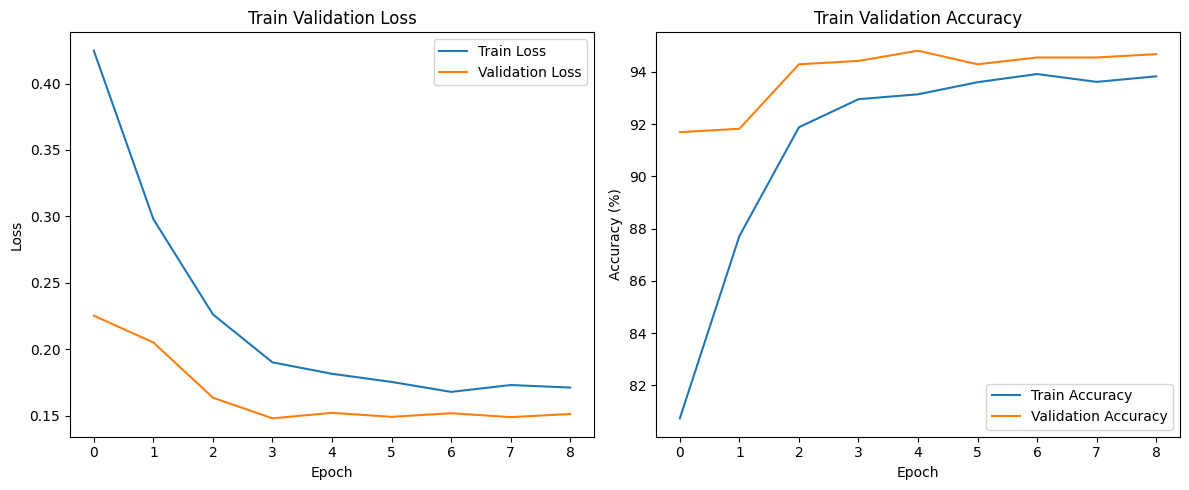

In [ ]:
history(train_losses, val_losses, accuracies, val_accuracies)

In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            outputs = model(inputs)
            predicted = (torch.sigmoid(outputs).squeeze() > 0.5).int()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Test Accuracy: {100 * correct / total:.2f}%')

evaluate_model(model, test_loader)

Test Accuracy: 93.38%


In [ ]:
class_names = ['Non-Risk Group (NRG)', 'Risk Group (RG)']

In [ ]:
def evaluate_with_matrix(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            outputs = model(inputs)
            predicted = (torch.sigmoid(outputs).squeeze() > 0.5).int()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    return cm, report

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
cm, report = evaluate_with_matrix(model, test_loader)

In [ ]:
print("Classification Report:")
print(report)
print("Confusion Matrix:")
print(cm)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.91      0.93       385
         1.0       0.91      0.96      0.94       385

    accuracy                           0.93       770
   macro avg       0.93      0.93      0.93       770
weighted avg       0.93      0.93      0.93       770

Confusion Matrix:
[[350  35]
 [ 16 369]]


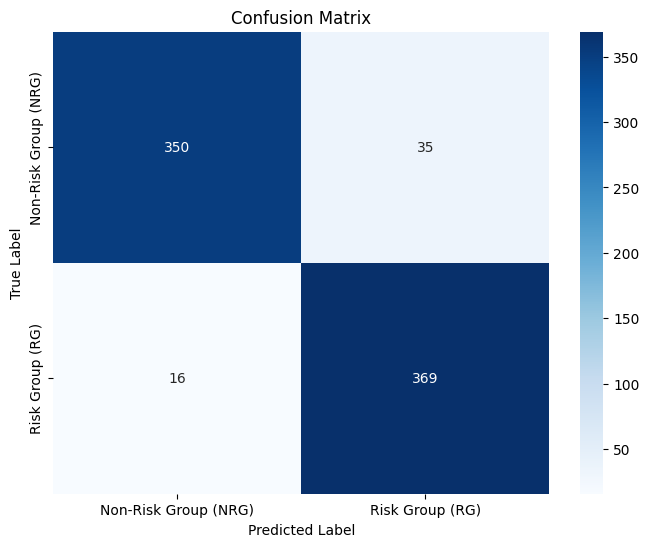

In [ ]:
plot_confusion_matrix(cm, class_names)

# Predict Image

In [ ]:
model.load_state_dict(torch.load("ResNet50_best_model.pth"))

<ipython-input-24-f710c55ca103>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("ResNet50_best_model.pth"))


<All keys matched successfully>

In [ ]:
def predict_image(model, image_path, transform, device):
    image = Image.open(image_path).convert("RGB")
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    image_tensor = transform(image).unsqueeze(0)
    image_tensor = image_tensor.to(device)

    model.eval()

    with torch.no_grad():
        output = model(image_tensor)
        prediction = torch.sigmoid(output).item()

    if prediction > 0.5:
        print(f"Prediksi RG: {prediction:.4f}")
    else:
        print(f"Prediksi NRG: {1 - prediction:.4f}")


In [ ]:
predict_transform = transforms.Compose([
    transforms.Resize((SIZE, SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

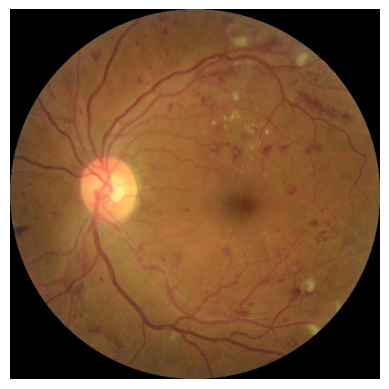

Prediksi NRG: 0.9967


In [ ]:
image_path = '/content/eyepac-light-v2-512-jpg/test/NRG/EyePACS-TRAIN-NRG-2888.jpg'
predict_image(model, image_path, predict_transform, device)